# Introduction

In this notebook we are going to download training data for the American Sign Language from Kaggle. This data will be processed and used to train a Convolutional Neural Network (CNN) to classify the images. 

The [American Sign Language alphabet](http://www.asl.gs/) contains 26 letters. Two of those letters (j and z) require movement, so they are not included in the training dataset.  The data set is unusual as it is contained in a CSV file so we will need to do some processing of the data. 

## Kaggle

We will download the data set from [Kaggle](http://www.kaggle.com) which contains a number of different data sets and examples we can look at. 

As usual we will test to see if we are in the lab and download the data set to the /transfer else locally. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import struct
import sys
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import zipfile
import string

# Visualization tools
import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import pandas as pd

sys.path.append("../")
import Utils

device = Utils.get_device()

DATASET_LOCATION = ""
if Utils.in_lab():
    DATASET_LOCATION = "/transfer/mnist_asl/"
else:
    DATASET_LOCATION = "./mnist_asl/"

print(f"Dataset location: {DATASET_LOCATION}")
pathlib.Path(DATASET_LOCATION).mkdir(parents=True, exist_ok=True)

Dataset location: ./mnist_asl/


We can use the Utils class to download the data set then unzip it.

In [2]:
URL = "https://www.kaggle.com/api/v1/datasets/download/nadaemad2002/asl-mnist"
desitnation = DATASET_LOCATION + "/asl-mnist.zip"
if not pathlib.Path(desitnation).exists():
    Utils.download(URL, desitnation)
    # now we need to unzip the file
    with zipfile.ZipFile(desitnation, "r") as zip_ref:
        zip_ref.extractall(DATASET_LOCATION)

## Data

Lets have a look at what we have downloaded, we can get a list of the files we have downloaded by using pathlib as follows.

In [3]:
for file in pathlib.Path(DATASET_LOCATION).glob("*"):
    print(file)

mnist_asl/asl-mnist.zip
mnist_asl/american_sign_language.PNG
mnist_asl/sign_mnist_test.csv
mnist_asl/sign_mnist_train
mnist_asl/sign_mnist_train.csv
mnist_asl/sign_mnist_test
mnist_asl/amer_sign3.png
mnist_asl/amer_sign2.png


There are two image files showing the the signs and two CSV files for the actual test and train data. 
![](./mnist_asl/american_sign_language.PNG)
![](./mnist_asl/amer_sign3.png)

## Processing the data with pandas

As the data is in csv format the easiest approach to processing it is to use the pandas library. We can read the csv file into a pandas dataframe and then process the data as required.


In [4]:
train_df = pd.read_csv(f"{DATASET_LOCATION}sign_mnist_train.csv")
valid_df = pd.read_csv(f"{DATASET_LOCATION}sign_mnist_test.csv")

We can now look at the data format and begin to process it into a more useful format for training the CNN.

In [5]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


 Each row is an image which has a `label` column followed by the pixel data (28 * 28 = 784 columns). The pixel data is in the range 0 to 255. We need to extract the label and pixel data and reshape the pixel data into a 28 x 28 image. We can get the labels by using the pandas pop method and the pixel data by using the pandas iloc method.

In [6]:
y_train = train_df.pop("label")
y_valid = valid_df.pop("label")
# look at the data
print(y_train.value_counts(sort=True, ascending=True).sort_index())
print(y_train.agg(["min", "max"]))

label
0     1126
1     1010
2     1144
3     1196
4      957
5     1204
6     1090
7     1013
8     1162
10    1114
11    1241
12    1055
13    1151
14    1196
15    1088
16    1279
17    1294
18    1199
19    1186
20    1161
21    1082
22    1225
23    1164
24    1118
Name: count, dtype: int64
min     0
max    24
Name: label, dtype: int64


In [7]:
x_train = train_df.values
x_valid = valid_df.values
print(x_train.shape, x_valid.shape)
print(type(x_train), type(x_valid))

(27455, 784) (7172, 784)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


If we look at the data we can see what it contains. We can use some of the pandas functions to find the min() and max() as well as sort and tabulate the data.

In [8]:
print(y_train.agg(["min", "max"]))
print(y_valid.agg(["min", "max"]))

print(y_train.value_counts(sort=True, ascending=True).sort_index())
print(y_valid.value_counts(sort=True, ascending=True).sort_index())

min     0
max    24
Name: label, dtype: int64
min     0
max    24
Name: label, dtype: int64
label
0     1126
1     1010
2     1144
3     1196
4      957
5     1204
6     1090
7     1013
8     1162
10    1114
11    1241
12    1055
13    1151
14    1196
15    1088
16    1279
17    1294
18    1199
19    1186
20    1161
21    1082
22    1225
23    1164
24    1118
Name: count, dtype: int64
label
0     331
1     432
2     310
3     245
4     498
5     247
6     348
7     436
8     288
10    331
11    209
12    394
13    291
14    246
15    347
16    164
17    144
18    246
19    248
20    266
21    346
22    206
23    267
24    332
Name: count, dtype: int64


As you can see the data ranges from 0-24 so whilst the J and the Z are missing the J value index (9) is still in the dataset, so we need to specify for 25 classes not 24.

## Visualizing the data

We can take a look at the data by writing a simple function to turn the nparrays into a 28 x 28 image and then display the image. Note that the labels are the numbers 0 to 24 and the letters are the alphabet minus j and z. We need to convert the labels to the letters for display purposes.

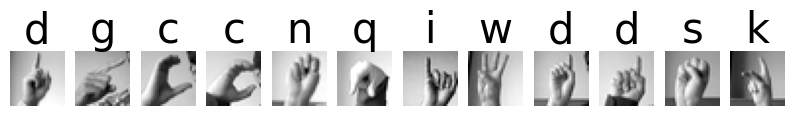

In [9]:
def plot_image(images, labels, num_images, image_index):
    image = images.reshape(28, 28)
    label = labels
    plt.subplot(1, num_images, image_index + 1)
    plt.title(label, fontdict={"fontsize": 30})
    plt.axis("off")
    plt.imshow(image, cmap="gray")


alphabet = string.ascii_letters[:25]

num_images = 12
plt.figure(figsize=(10, 10))
for x in range(num_images):
    row = x_train[x]
    label = y_train[x]
    plot_image(row, alphabet[label], num_images, x)

We can now normalize our image data so it is in the range 0 to 1. We can do this by dividing the pixel data by 255 (as they are nparrays this will be element wise division).

In [10]:
x_train = train_df.values / 255
x_valid = valid_df.values / 255

## Generating a Dataset

As we did in the previous example we can create a dataset class to represent our data. Again this will be a simple image / label dataset.

In [11]:
class ASLDataSet(Dataset):
    def __init__(self, x_df, y_df):
        print(device)
        self.xs = torch.tensor(x_df).float().to(device)
        self.ys = torch.tensor(y_df).to(device)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

    def __len__(self):
        return len(self.xs)

In [12]:
BATCH_SIZE = 32

train_data = ASLDataSet(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
train_N = len(train_loader.dataset)

valid_data = ASLDataSet(x_valid, y_valid)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)
valid_N = len(valid_loader.dataset)

print(f"Train size: {train_N}, Valid size: {valid_N}")

mps
mps
Train size: 27455, Valid size: 7172


## Building a Model

In this example we will use a similar approach to the Digits example Where we used a Linear model. 


* Has a flatten layer.
* Has a dense input layer. This layer should contain 512 neurons amd use the `relu` activation function
* Has a second dense layer with 512 neurons which uses the `relu` activation function
* Has a dense output layer with neurons equal to the number of classes

We will define a few variables to get started: 

The size of the images is 28 x 28 and there are 24 classes (the alphabet minus j and z).

In [13]:
input_size = 28 * 28
n_classes = 25

We can add the layers to the model using the nn.Sequential class. See if you can think of what we should do next.

<details>

<summary>Solution</summary>

```python
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
    nn.Linear(512, 512),  # Hidden
    nn.ReLU(),  # Activation for hidden
    nn.Linear(512, n_classes)  # Output
)
```

</details>



In [14]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
    nn.Linear(512, 512),  # Hidden
    nn.ReLU(),  # Activation for hidden
    nn.Linear(512, n_classes),  # Output
)

We can compile and send the model to the device.

In [15]:
if device == "cuda":
    model = torch.compile(model.to(device))
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=25, bias=True)
)

Since categorizing these ASL images is similar to categorizing MNIST's handwritten digits, we will use the same `loss_function` ([Categorical CrossEntropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) and `optimizer` ([Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)) as we used in the last example.

In [16]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())

## Training

The data in the DataLoader is already on the GPU so we can now just process it in the same way as we did in the previous example.

The steps are the same as before. 


1. Get an `output` prediction from the model
2. Set the gradient to zero with the `optimizer`'s [zero_grad](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html) function
3. Calculate the loss with our `loss_function`
4. Compute the gradient with [backward](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html)
5. Update our model parameters with the `optimizer`'s [step](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html) function.
6. Update the `loss` and `accuracy` totals

In [17]:
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N


#  we are going to store the accuracy and loss for each epoch
train_accuracy = []
train_loss = []


def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()
        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    train_accuracy.append(accuracy)
    train_loss.append(loss)
    print("Train - Loss: {:.4f} Accuracy: {:.4f}".format(loss, accuracy))

## Validate Function

The core part of the validate process is to set the model to evaluation mode with the `model.eval()` function. This will turn off dropout and batch normalization. We then loop through the validation data and calculate the loss and accuracy in the same way as we did for the training data.

More details of [model.evaluate](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval) can be found here.

In [18]:
valid_accuracy = []
valid_loss = []


def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)
            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    valid_accuracy.append(accuracy)
    valid_loss.append(loss)
    print("Valid - Loss: {:.4f} Accuracy: {:.4f}".format(loss, accuracy))

## Training

Finally we can train the model as before.

In [19]:
epochs = 10

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    train()
    validate()

Epoch: 0
Train - Loss: 1583.6311 Accuracy: 0.4003
Valid - Loss: 313.7317 Accuracy: 0.5393
Epoch: 1
Train - Loss: 729.2652 Accuracy: 0.7129
Valid - Loss: 244.0333 Accuracy: 0.6479
Epoch: 2
Train - Loss: 394.4886 Accuracy: 0.8468
Valid - Loss: 228.8636 Accuracy: 0.7061
Epoch: 3
Train - Loss: 220.0661 Accuracy: 0.9192
Valid - Loss: 234.9380 Accuracy: 0.7257
Epoch: 4
Train - Loss: 132.9735 Accuracy: 0.9537
Valid - Loss: 242.6011 Accuracy: 0.7266
Epoch: 5
Train - Loss: 84.0148 Accuracy: 0.9717
Valid - Loss: 241.8591 Accuracy: 0.7631
Epoch: 6
Train - Loss: 79.4884 Accuracy: 0.9706
Valid - Loss: 230.8674 Accuracy: 0.7612
Epoch: 7
Train - Loss: 77.2359 Accuracy: 0.9725
Valid - Loss: 267.0333 Accuracy: 0.7472
Epoch: 8
Train - Loss: 58.0807 Accuracy: 0.9796
Valid - Loss: 246.0040 Accuracy: 0.7352
Epoch: 9
Train - Loss: 39.6228 Accuracy: 0.9868
Valid - Loss: 225.8812 Accuracy: 0.8035


## Discussion

Our models doesn't seem to be getting very good results. We can see that the training accuracy seems to a fairly high level, but the validation accuracy was not as high. This is a sign of overfitting, which means that is it guessing against a learnt data set and never generalizing to new data.

As we have accumulated the data when training, we can plot this out to see how things went. 


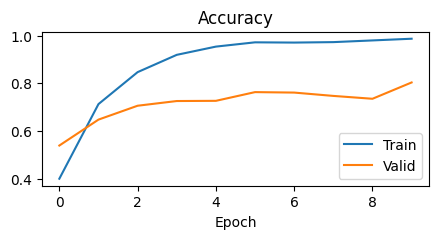

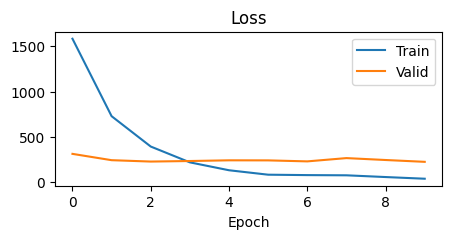

In [20]:
# Lets plot the data
plt.figure(figsize=(5, 2))
plt.plot(train_accuracy, label="Train")
plt.plot(valid_accuracy, label="Valid")
plt.xlabel("Epoch")
plt.title("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(5, 2))
plt.plot(train_loss, label="Train")
plt.plot(valid_loss, label="Valid")
plt.xlabel("Epoch")
plt.title("Loss")
plt.legend()
plt.show()

We should see that the lines are diverging, which is a sign of overfitting. We need to look at a different model to make this work better. In particular we are going to build a CNN model to see if this can improve the accuracy.